In [1]:
import numpy as np
from collections import Counter
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from create_datasets import *
from sklearn.metrics import accuracy_score

In [2]:
final_edges = np.load('../datasets/final_edges.dump', allow_pickle=True)
data = generate_fingerprints(final_edges)

  0%|          | 0/87153 [00:00<?, ?it/s]

  0%|          | 0/87153 [00:00<?, ?it/s]

  0%|          | 0/87153 [00:00<?, ?it/s]

/home2/kanakala.ganesh/ML4NS/src/create_datasets.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  i[2]


0it [00:00, ?it/s]

In [21]:
class MyConv1dPadSame(nn.Module):
    """
    extend nn.Conv1d to support SAME padding
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, groups=1):
        super(MyConv1dPadSame, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.groups = groups
        self.conv = torch.nn.Conv1d(
            in_channels=self.in_channels, 
            out_channels=self.out_channels, 
            kernel_size=self.kernel_size, 
            stride=self.stride, 
            groups=self.groups)

    def forward(self, x):
        
        net = x
        
        # compute pad shape
        in_dim = net.shape[-1]
        out_dim = (in_dim + self.stride - 1) // self.stride
        p = max(0, (out_dim - 1) * self.stride + self.kernel_size - in_dim)
        pad_left = p // 2
        pad_right = p - pad_left
        net = F.pad(net, (pad_left, pad_right), "constant", 0)
        
        net = self.conv(net)

        return net
        
class MyMaxPool1dPadSame(nn.Module):
    """
    extend nn.MaxPool1d to support SAME padding
    """
    def __init__(self, kernel_size):
        super(MyMaxPool1dPadSame, self).__init__()
        self.kernel_size = kernel_size
        self.stride = 1
        self.max_pool = torch.nn.MaxPool1d(kernel_size=self.kernel_size)

    def forward(self, x):
        
        net = x
        
        # compute pad shape
        in_dim = net.shape[-1]
        out_dim = (in_dim + self.stride - 1) // self.stride
        p = max(0, (out_dim - 1) * self.stride + self.kernel_size - in_dim)
        pad_left = p // 2
        pad_right = p - pad_left
        net = F.pad(net, (pad_left, pad_right), "constant", 0)
        
        net = self.max_pool(net)
        
        return net
    
class BasicBlock(nn.Module):
    """
    ResNet Basic Block
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, groups, downsample, use_bn, use_do, is_first_block=False):
        super(BasicBlock, self).__init__()
        
        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.out_channels = out_channels
        self.stride = stride
        self.groups = groups
        self.downsample = downsample
        if self.downsample:
            self.stride = stride
        else:
            self.stride = 1
        self.is_first_block = is_first_block
        self.use_bn = use_bn
        self.use_do = use_do

        # the first conv
        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu1 = nn.ReLU()
        self.do1 = nn.Dropout(p=0.5)
        self.conv1 = MyConv1dPadSame(
            in_channels=in_channels, 
            out_channels=out_channels, 
            kernel_size=kernel_size, 
            stride=self.stride,
            groups=self.groups)

        # the second conv
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu2 = nn.ReLU()
        self.do2 = nn.Dropout(p=0.5)
        self.conv2 = MyConv1dPadSame(
            in_channels=out_channels, 
            out_channels=out_channels, 
            kernel_size=kernel_size, 
            stride=1,
            groups=self.groups)
                
        self.max_pool = MyMaxPool1dPadSame(kernel_size=self.stride)

    def forward(self, x):
        
        identity = x
        
        # the first conv
        out = x
        if not self.is_first_block:
            if self.use_bn:
                out = self.bn1(out)
            out = self.relu1(out)
            if self.use_do:
                out = self.do1(out)
        out = self.conv1(out)
        
        # the second conv
        if self.use_bn:
            out = self.bn2(out)
        out = self.relu2(out)
        if self.use_do:
            out = self.do2(out)
        out = self.conv2(out)
        
        # if downsample, also downsample identity
        if self.downsample:
            identity = self.max_pool(identity)
            
        # if expand channel, also pad zeros to identity
        if self.out_channels != self.in_channels:
            identity = identity.transpose(-1,-2)
            ch1 = (self.out_channels-self.in_channels)//2
            ch2 = self.out_channels-self.in_channels-ch1
            identity = F.pad(identity, (ch1, ch2), "constant", 0)
            identity = identity.transpose(-1,-2)
        
        # shortcut
        out += identity

        return out
    
class ResNet1D(nn.Module):
    """
    
    Input:
        X: (n_samples, n_channel, n_length)
        Y: (n_samples)
        
    Output:
        out: (n_samples)
        
    Pararmetes:
        in_channels: dim of input, the same as n_channel
        base_filters: number of filters in the first several Conv layer, it will double at every 4 layers
        kernel_size: width of kernel
        stride: stride of kernel moving
        groups: set larget to 1 as ResNeXt
        n_block: number of blocks
        n_classes: number of classes
        
    """

    def __init__(self, in_channels=1, base_filters=32, kernel_size=3, stride=1, groups=1, n_block=3, n_classes=2, downsample_gap=2, increasefilter_gap=4, use_bn=True, use_do=True, verbose=False):
        super(ResNet1D, self).__init__()
        
        self.verbose = verbose
        self.n_block = n_block
        self.kernel_size = kernel_size
        self.stride = stride
        self.groups = groups
        self.use_bn = use_bn
        self.use_do = use_do

        self.downsample_gap = downsample_gap # 2 for base model
        self.increasefilter_gap = increasefilter_gap # 4 for base model

        # first block
        self.first_block_conv = MyConv1dPadSame(in_channels=in_channels, out_channels=base_filters, kernel_size=self.kernel_size, stride=1)
        self.first_block_bn = nn.BatchNorm1d(base_filters)
        self.first_block_relu = nn.ReLU()
        out_channels = base_filters
                
        # residual blocks
        self.basicblock_list = nn.ModuleList()
        for i_block in range(self.n_block):
            # is_first_block
            if i_block == 0:
                is_first_block = True
            else:
                is_first_block = False
            # downsample at every self.downsample_gap blocks
            if i_block % self.downsample_gap == 1:
                downsample = True
            else:
                downsample = False
            # in_channels and out_channels
            if is_first_block:
                in_channels = base_filters
                out_channels = in_channels
            else:
                # increase filters at every self.increasefilter_gap blocks
                in_channels = int(base_filters*2**((i_block-1)//self.increasefilter_gap))
                if (i_block % self.increasefilter_gap == 0) and (i_block != 0):
                    out_channels = in_channels * 2
                else:
                    out_channels = in_channels
            
            tmp_block = BasicBlock(
                in_channels=in_channels, 
                out_channels=out_channels, 
                kernel_size=self.kernel_size, 
                stride = self.stride, 
                groups = self.groups, 
                downsample=downsample, 
                use_bn = self.use_bn, 
                use_do = self.use_do, 
                is_first_block=is_first_block)
            self.basicblock_list.append(tmp_block)

        # final prediction
        self.final_bn = nn.BatchNorm1d(out_channels)
        self.final_relu = nn.ReLU(inplace=True)
        # self.do = nn.Dropout(p=0.5)
        self.dense = nn.Linear(out_channels, n_classes)
        # self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):   
        
        out = self.first_block_conv(x)
 
        if self.use_bn:
            out = self.first_block_bn(out)
        out = self.first_block_relu(out)
        
        # residual blocks, every block has two conv
        for i_block in range(self.n_block):
            net = self.basicblock_list[i_block]           
            out = net(out)

        # final prediction
        if self.use_bn:
            out = self.final_bn(out)
        out = self.final_relu(out)
        out = out.mean(-1)

        # out = self.do(out)
        out = self.dense(out)
    
        
        return out

In [22]:
class FullNet(nn.Module):
    def __init__(self, finger_print_model, graph_embedding_model, combined_model):
        super().__init__()
        self.FP_model = finger_print_model
        self.GE_model = graph_embedding_model
        self.CB_model = combined_model
    
    def forward(self, fp, ge):
        fp_out = self.FP_model(fp)
        ge_out = self.GE_model(ge)
        inp = torch.cat((fp_out, ge_out), 1)
        inp = inp.unsqueeze(1)
        out = self.CB_model(inp)
        return out

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# device= 'cpu'

cuda


In [31]:
dataset = LinkDataset(data)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train , test = torch.utils.data.random_split(dataset, [train_size, test_size])
BATCH_SIZE = 256
trainloader = DataLoader(train, num_workers = 16, batch_size= BATCH_SIZE)
testloader = DataLoader(test, num_workers = 16, batch_size= BATCH_SIZE)

In [32]:
model = FullNet(ResNet1D(n_classes=256), 
                ResNet1D(n_classes=256), 
                ResNet1D(n_classes=2))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-6)

In [33]:
!nvidia-smi

Tue May 10 15:42:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:02:00.0 Off |                  N/A |
| 50%   45C    P2    55W / 250W |   4896MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:03:00.0 Off |                  N/A |
| 36%   

In [34]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+----------------------------------------------+------------+
|                   Modules                    | Parameters |
+----------------------------------------------+------------+
|    FP_model.first_block_conv.conv.weight     |     96     |
|     FP_model.first_block_conv.conv.bias      |     32     |
|        FP_model.first_block_bn.weight        |     32     |
|         FP_model.first_block_bn.bias         |     32     |
|    FP_model.basicblock_list.0.bn1.weight     |     32     |
|     FP_model.basicblock_list.0.bn1.bias      |     32     |
| FP_model.basicblock_list.0.conv1.conv.weight |    3072    |
|  FP_model.basicblock_list.0.conv1.conv.bias  |     32     |
|    FP_model.basicblock_list.0.bn2.weight     |     32     |
|     FP_model.basicblock_list.0.bn2.bias      |     32     |
| FP_model.basicblock_list.0.conv2.conv.weight |    3072    |
|  FP_model.basicblock_list.0.conv2.conv.bias  |     32     |
|    FP_model.basicblock_list.1.bn1.weight     |     32     |
|     FP

74754

In [35]:
def eval(model,testloader):
    model.eval()
    test_loss = 0.0
    preds = []
    trues = []
    for fp, ge, label in testloader:
        output = model(fp.float().to(device),ge.float().to(device))
        loss = criterion(output, label.float().to(device))
        test_loss+=loss.item()
        for i in range(len(output)):
            pred = output[i].argmax().item()
            true = label[i].argmax().item()
            preds.append(pred)
            trues.append(true)
    model.train()
    print("Accuracy", accuracy_score(preds, trues))
    return accuracy_score(preds, trues), test_loss / len(testloader)

In [36]:
train_losses = []
test_losses = []
num_epochs= 50
best_acc = 0.0
acc_list = []
for epoch in tqdm(range(1, num_epochs)):
    train_loss = 0.0
    model.train()
    batch_id = 0
    for fp, ge, label in trainloader:
        batch_id +=1
        
        optimizer.zero_grad()
        output = model(fp.float().to(device),ge.float().to(device))
        loss = criterion(output, label.float().to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() 
    
        print(f'Epoch:{epoch} batch {batch_id}/{len(trainloader)} loss:{loss.item()}', end='\r')
    
    acc, test_loss = eval(model, testloader)
    acc_list.append(acc)

    if acc > best_acc:
        best_acc = acc
        print("Improved Accuracy is", acc )
        torch.save(model, 'SAVED_MODELS/Resnet-bestmodel_1.pt')
        with open('SAVED_MODELS/Resnet-bestmodel_1.txt', 'w') as f:
            print(model.eval() , "Accuracy" , acc, file=f)

#     else:
#         model = torch.load('SAVED_MODELS/Resnet-bestmodel_1.pt')
    
    print()
    print("Train loss: ",train_loss/len(trainloader))
    print("Test  loss: ",test_loss)
    
    train_losses.append(train_loss/len(trainloader))
    test_losses.append(test_loss)

  0%|          | 0/49 [00:00<?, ?it/s]

Accuracy 0.66077677700648270.6967446208000183
Improved Accuracy is 0.6607767770064827

Train loss:  0.698000159237411
Test  loss:  0.6820895628652711
Accuracy 0.66077677700648270.6962059140205383

Train loss:  0.6963077602369008
Test  loss:  0.681631294713504
Accuracy 0.66077677700648270.6943146586418152

Train loss:  0.6946846561117487
Test  loss:  0.6810311104940332
Accuracy 0.66077677700648270.6907749176025391

Train loss:  0.6930543201746958
Test  loss:  0.68034046024516
Accuracy 0.66077677700648270.6901251673698425

Train loss:  0.6914575907773587
Test  loss:  0.6795032024383545
Accuracy 0.66077677700648270.6888172030448914

Train loss:  0.6899348327091762
Test  loss:  0.6786490065464075
Accuracy 0.66077677700648270.6885214447975159

Train loss:  0.6884137505576724
Test  loss:  0.6777249375979105
Accuracy 0.66077677700648270.6873291134834295

Train loss:  0.686863824561402
Test  loss:  0.6767773896023848
Accuracy 0.66077677700648270.6878119111061096

Train loss:  0.685447722564250

In [ ]:
# import gc
# gc.collect()
# torch.cuda.empty_cache()

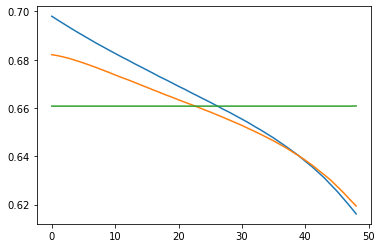

In [38]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(test_losses)
plt.plot(acc_list)

In [39]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
def get_performance(model, testloader):
    model.eval()
    test_loss = 0.0
    preds = []
    trues = []
    for fp, ge, label in testloader:
        output = model(fp.float().to(device),ge.float().to(device))
        loss = criterion(output, label.float().to(device))
        test_loss+=loss.item()
        for i in range(len(output)):
            pred = output[i].argmax().item()
            true = label[i].argmax().item()
            preds.append(pred)
            trues.append(true)
    model.train()
    print(classification_report(trues, preds, labels=[0,1]))
    print()
    cm = confusion_matrix(trues, preds, labels=[0,1])
    disp = ConfusionMatrixDisplay(cm, np.array([0,1]))
    disp.plot()
    plt.show()

              precision    recall  f1-score   support

           0       0.66      1.00      0.80     11518
           1       1.00      0.00      0.00      5913

    accuracy                           0.66     17431
   macro avg       0.83      0.50      0.40     17431
weighted avg       0.78      0.66      0.53     17431




/home2/kanakala.ganesh/miniconda3/envs/fast/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass display_labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


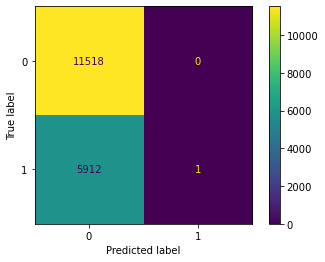

In [40]:
get_performance(model, testloader)